In [1]:
#pip uninstall pywin32

In [ ]:
pip install pywin32

In [1]:
import gc
gc.collect(generation=2)

246

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pmdarima as pm
import math
from pmdarima.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
# 포트폴리오 관련 library import

import cvxopt as opt # python version 3.6-3.10 가능
from cvxopt import solvers
from pypfopt.efficient_frontier import EfficientFrontier # 정확하게는 모르겠는데 3.7은 사용가능
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [4]:
df = pd.read_csv("C:/Users/User/github/Web_crawling/save_data/stock_data.csv", encoding='cp949')
score = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/total_count.csv", encoding='cp949')

In [5]:
df.set_index('time', inplace=True)
#df['time'] = pd.DatetimeIndex(df['time'])

In [6]:
# train 데이터와 validation 데이터 나누기.
X_train = df[df.index < '2019-01-01']
X_valid = df[df.index >= '2019-01-01']

# 각 데이터의 사이즈 확인하기
print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train Shape (180, 21)
X_Valid Shape (48, 21)


---
#### train 구간만 사용한 포트폴리오와 예측 구간까지 사용한 포트폴리오의 차이를 확인할 것임
#### train 구간이 움직일때 포트폴리오를 다시 최적화 할것임.
#### 즉 한달 주기로 포트폴리오를 다시 구성한다고 생각하면 될것.
#### 수수료는 없다고 가정
#### 처음 주식을 구매하고 주식을 전부 판매하고 다시 주식을 구매하는 것으로 돈을 계속 계산할 것임

In [7]:
weights = np.ones(21) # 초기에 가중치를 1로 설정
weights = weights/21 # 이후 동일하게 1/22으로 나눠서 설정 (가중치 합은 항상 1)

returns=X_train.pct_change() # 단순 수익률 계산 => (다음날 값 +- 기준일 값)/기준일 값 으로 수익률 나옵니다.

cov_matrix_annual=returns.cov()*12 # 데이터 기준이 DAY가 아니라 MONTH이므로 12를 곱해 연간 수익률로 계산

port_variance= weights.T @ cov_matrix_annual @ weights # 포트폴리오 분산의 기대값 = WT * (공분산{= 시그마}) * W를 코드로 옆처럼 나타냄

port_volatility=np.sqrt(port_variance) # 포트폴리오 변동성의 기대값 = SQRT(WT * 공분산(=시그마) * W) // 그냥 표준편차 = 변동성

portfolioSimpleAnnualReturn=np.sum(returns.mean()*weights)*12 # 연간 수익률 계산 DAY가 아니라 MONTH기준이므로 12곱하면 됨

In [8]:
percent_var=str(round(port_variance,2)*100)+'%'
percent_vol=str(round(port_volatility,2)*100)+'%'
percent_ret=str(round(portfolioSimpleAnnualReturn,2)*100)+'%'

In [9]:
print('Expected Annual Return :'+ percent_ret )
print('Annual Volatility/risk :'+ percent_vol )
print('Annual Variance :'+ percent_var )

Expected Annual Return :9.0%
Annual Volatility/risk :19.0%
Annual Variance :4.0%


In [10]:
1000000000000*weights/ X_train.iloc[-1,:] @ X_valid.iloc[-1,:]

1017609252337.6196

In [11]:
# Portfolio optimization

# Calculate the expexted returns and annualised sample covariance matrix of the asset returns
mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준

# Optimize the max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
#weights = ef.max_sharpe()
#weights = ef.max_quadratic_utility() 

cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

latest_prices = get_latest_prices(X_train)
weights = cleaned_weights 

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000000000)
allocation, leftover = da.lp_portfolio()

print("Discrete allocation:", allocation) # 해당주를 얼마나 구입하는가
print("Funds remaining: ${:.2f}".format(leftover)) # 예상 수익

OrderedDict([('음식료품', 0.25419), ('섬유의복', 0.01637), ('종이목재', 0.0), ('화학', 0.00216), ('의약품', 0.0), ('비금속광물', 0.0), ('철강금속', 0.0), ('기계', 0.0), ('전기전자', 0.19938), ('의료정밀', 0.0), ('운수장비', 0.0), ('유통업', 0.0), ('전기가스업', 0.08899), ('건설업', 0.0), ('운수창고업', 0.0), ('통신업', 0.38124), ('금융업', 0.0), ('은행', 0.0), ('증권', 0.0), ('보험', 0.00407), ('서비스업', 0.0536)])
Expected annual return: 4.8%
Annual volatility: 13.4%
Sharpe Ratio: 0.21
Discrete allocation: {'음식료품': 64189231, '섬유의복': 64573390, '화학': 443083, '전기전자': 13800770, '전기가스업': 84703979, '통신업': 957913515, '보험': 249643, '서비스업': 49629630}
Funds remaining: $1636.48


In [12]:
l = pd.DataFrame(index=range(0,1), columns = df.columns)
l_2 = pd.merge(l, pd.DataFrame.from_dict(data = allocation, orient='index', dtype='int').T, how = 'outer').fillna(0)
l_2.iloc[1,:]@X_valid.iloc[-1,:].T # 포트폴리오 실제 수익

1052820005895.61

### Moving window

In [13]:
# Portfolio optimization

# Calculate the expexted returns and annualised sample covariance matrix of the asset returns
mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준

# Optimize the max sharpe ratio
ef = EfficientFrontier(mu, S)
#weights = ef.min_volatility()
#weights = ef.max_sharpe()
weights = ef.max_quadratic_utility() 
cleaned_weights = ef.clean_weights() 

latest_prices = get_latest_prices(X_train)
weights = cleaned_weights 

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000000000)
allocation, leftover = da.lp_portfolio()

print("Discrete allocation:", allocation) # 해당주를 얼마나 구입하는가
print("Funds remaining: ${:.2f}".format(leftover)) # 예상 수익

Discrete allocation: {'의약품': 86009001}
Funds remaining: $8163.31


----
### 뉴스 정보와 결합

In [14]:
score = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/total_count.csv", encoding='cp949')

In [15]:
score_df = score[['음식료품_positive_rate','섬유의복_positive_rate','종이목재_positive_rate','화학_positive_rate','의약품_positive_rate','비금속광물_positive_rate','철강금속_positive_rate','기계_positive_rate','전기전자_positive_rate','의료정밀_positive_rate','운수장비_positive_rate','유통업_positive_rate','전기가스업_positive_rate','건설업_positive_rate','운수창고_positive_rate','통신업_positive_rate','금융업_positive_rate','은행_positive_rate','증권_positive_rate','보험_positive_rate','서비스업_positive_rate']]
score_df.columns = df.columns
score_df = score_df.fillna(int(0))
score_df['time'] = pd.date_range('2013-01-01','2022-12-31',freq='m')
score_df['time'] = score_df['time'].astype(str)
score_df.set_index('time', inplace=True) 
#score_df = score_df.set_index(pd.date_range('2013-01-01','2022-12-31',freq='m'))
z = []
for i in range(0,len(score_df.columns)):
    z.append((list(cleaned_weights.values())[i] + score_df.iloc[1,i])/2)

In [16]:
K = np.where(score_df.index == '2016-01-31') 
score_df.iloc[K[0][0],:]

음식료품     0.833333
섬유의복     1.000000
종이목재     1.000000
화학       0.454545
의약품      0.000000
비금속광물    0.714286
철강금속     0.600000
기계       0.700000
전기전자     0.400000
의료정밀     1.000000
운수장비     1.000000
유통업      1.000000
전기가스업    1.000000
건설업      0.000000
운수창고업    0.600000
통신업      1.000000
금융업      1.000000
은행       1.000000
증권       0.800000
보험       1.000000
서비스업     1.000000
Name: 2016-01-31, dtype: float64

In [28]:
a = 1000000000
solution = []
money = []
sol = pd.DataFrame(index=range(0,1), columns = df.columns)
finish_mat = pd.DataFrame(index = range(0,1), columns = df.columns)

for i in range(0,len(X_valid)):
    check = str(pd.date_range('2019-01-01','2022-12-31',freq='m')[i])[0:10]
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준
        ef = EfficientFrontier(mu, S)
        weights_2 = ef.min_volatility() 
        cleaned_weights = ef.clean_weights() # 1e-16 같은거 0으로 바꿔줌
        test_table = get_latest_prices(X_train)
        j = np.where(score_df.index == check) 
        finish_weight = (( list(cleaned_weights.values()) + score_df.iloc[j[0][0],:] )/2)
        sum = finish_weight.sum()
        finish_weight_2 = (finish_weight/sum).round(3) 

    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
        ef = EfficientFrontier(mu,S)
        weights_2 = ef.min_volatility()    
        cleaned_weights = ef.clean_weights() 
        test_table = get_latest_prices(X_valid.iloc[i:,:])
        j = np.where(score_df.index == check) 
        finish_weight = (( list(cleaned_weights.values()) + score_df.iloc[j[0][0],:] )/2)
        sum = finish_weight.sum()
        finish_weight_2 = (finish_weight/sum).round(3)

    da = DiscreteAllocation(dict(finish_weight_2), test_table, total_portfolio_value = a)

    solution.append(da.lp_portfolio())
    money.append(a)
    mat = pd.DataFrame.from_dict(data = solution[i][0], orient='index', dtype='int').T
    sol = pd.merge(sol, pd.DataFrame.from_dict(data = solution[i][0], orient='index', dtype='int').T, how = 'outer').fillna(0) 
    a += pd.DataFrame(solution).iloc[i,1]*1200
#sol.drop(columns='time', inplace = True)

: 

: 

In [27]:
finish_weight_2.sum()

1.0010000000000001

In [24]:
finish_weight_2

음식료품     0.359
섬유의복     0.277
종이목재     0.165
화학       0.157
의약품      0.126
비금속광물    0.165
철강금속     0.275
기계       0.115
전기전자     0.222
의료정밀     0.138
운수장비     0.183
유통업      0.275
전기가스업    0.278
건설업      0.275
운수창고업    0.220
통신업      0.291
금융업      0.138
은행       0.206
증권       0.220
보험       0.281
서비스업     0.275
Name: 2022-12-31, dtype: float64

In [ ]:
finish_weight_2.sum()

0.9970000000000001

In [ ]:
finish_weight_2.round(2).sum()

1.0000000000000002

In [ ]:
finish_weight.sum().round(2)

8.44

In [ ]:
b = 1000000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)

for i in range(0,len(X_valid)):
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준
        ef = EfficientFrontier(mu, S)
        weights_2 = ef.min_volatility() 
        cleaned_weights = ef.clean_weights() # 1e-16 같은거 0으로 바꿔줌
        test_table = get_latest_prices(X_train)

    
    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
        #table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:].T])
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
        ef = EfficientFrontier(mu,S)
        weights_2 = ef.min_volatility()    
        cleaned_weights = ef.clean_weights() 
        test_table = get_latest_prices(X_valid.iloc[i:,:])
    
    da = DiscreteAllocation(cleaned_weights, test_table, total_portfolio_value = int(b))

    solution_2.append(da.lp_portfolio())
    money_2.append(b)
    sol_2 = pd.merge(sol_2, pd.DataFrame.from_dict(data = solution_2[i][0], orient='index', dtype='int').T, how = 'outer').fillna(0)
    b += pd.DataFrame(solution_2).iloc[i,1]*1200
#sol_2.drop(columns='time', inplace = True)

In [ ]:
z = []
for i in range(0,len(score_df.columns)):
    z.append((list(cleaned_weights.values())[i] + score_df.iloc[1,i])/2)

In [ ]:
score_df.iloc[1,1]

0.7857142857142857

### 시각화

Text(0.5, 1.0, '포트폴리오 업데이트 횟수별 예상 누적 수익 변화')

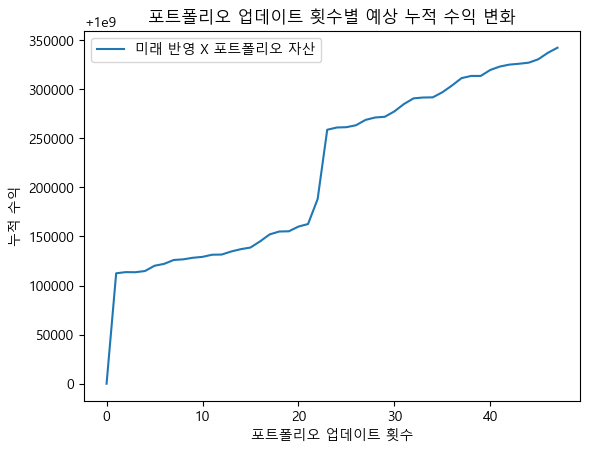

In [ ]:
#plt.plot((pd.DataFrame(money)), label = '미래 반영 포트폴리오 자산')
plt.plot((pd.DataFrame(money)), label = '미래 반영 X 포트폴리오 자산')
plt.xlabel('포트폴리오 업데이트 횟수')
plt.ylabel('누적 수익')
plt.legend()
plt.title('포트폴리오 업데이트 횟수별 예상 누적 수익 변화')

Text(0.5, 1.0, '포트폴리오 업데이트 횟수별 예상 누적 수익 변화')

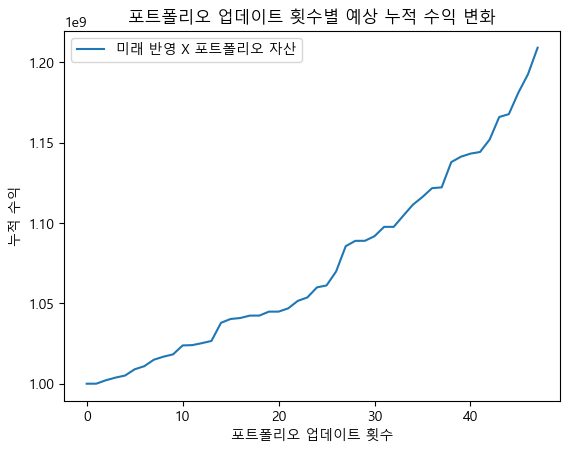

In [ ]:
#plt.plot((pd.DataFrame(money)), label = '미래 반영 포트폴리오 자산')
plt.plot((pd.DataFrame(money_2)), label = '미래 반영 X 포트폴리오 자산')
plt.xlabel('포트폴리오 업데이트 횟수')
plt.ylabel('누적 수익')
plt.legend()
plt.title('포트폴리오 업데이트 횟수별 예상 누적 수익 변화')

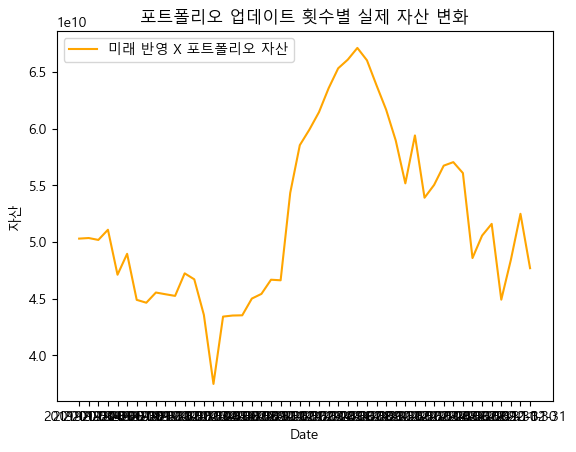

In [ ]:
#plt.plot((sol@predict.T).sum(), label ='미래 반영 포트폴리오 자산')
plt.plot((sol@X_valid.T).sum(), label = '미래 반영 X 포트폴리오 자산', color = 'orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('자산')
plt.title('포트폴리오 업데이트 횟수별 실제 자산 변화')
plt.show()

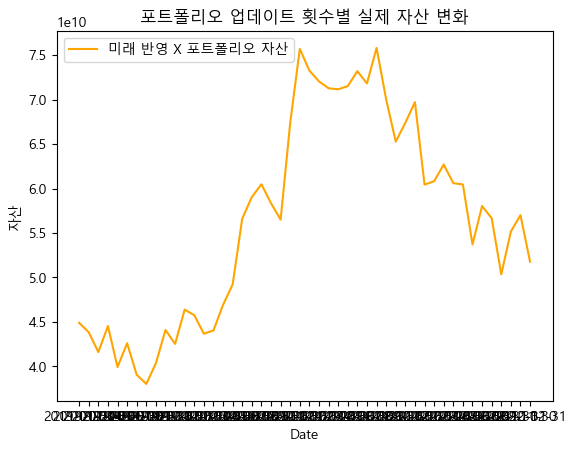

In [ ]:
#plt.plot((sol@predict.T).sum(), label ='미래 반영 포트폴리오 자산')
plt.plot((sol_2@X_valid.T).sum(), label = '미래 반영 X 포트폴리오 자산', color = 'orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('자산')
plt.title('포트폴리오 업데이트 횟수별 실제 자산 변화')
plt.show()

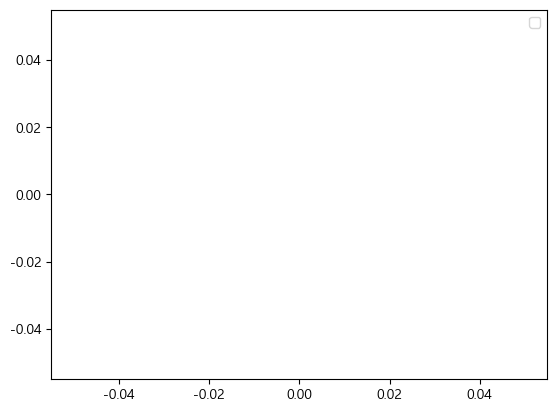

In [ ]:
for i in range(len(sol.columns)):
    globals()['h{}'.format(i)] = plt.plot(sol.iloc[:,i])
    'h{}'.format(i)
plt.legend(handles=(h2, h3, h4, h5, h9, h10, h18),labels = {'섬유의복','종이목재','화학','의약품','전기전자','의료정밀','은행'}, loc='best' )
plt.show()
# 범례 안보임..

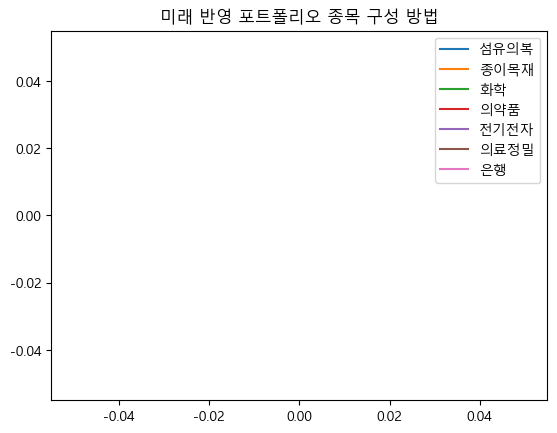

In [ ]:
plt.plot(sol.iloc[:,2], label = '섬유의복')
plt.plot(sol.iloc[:,3], label = '종이목재')
plt.plot(sol.iloc[:,4], label = '화학')
plt.plot(sol.iloc[:,5], label = '의약품')
plt.plot(sol.iloc[:,9], label = '전기전자')
plt.plot(sol.iloc[:,10], label = '의료정밀')
plt.plot(sol.iloc[:,18], label = '은행')
plt.legend()
plt.title('미래 반영 포트폴리오 종목 구성 방법')
plt.show()

In [ ]:
sol_2.sum()!=0

음식료품     False
섬유의복     False
종이목재      True
화학        True
의약품       True
비금속광물    False
철강금속     False
기계       False
전기전자      True
의료정밀      True
운수장비     False
유통업       True
전기가스업    False
건설업       True
운수창고업    False
통신업      False
금융업       True
은행       False
증권       False
보험       False
서비스업     False
dtype: bool

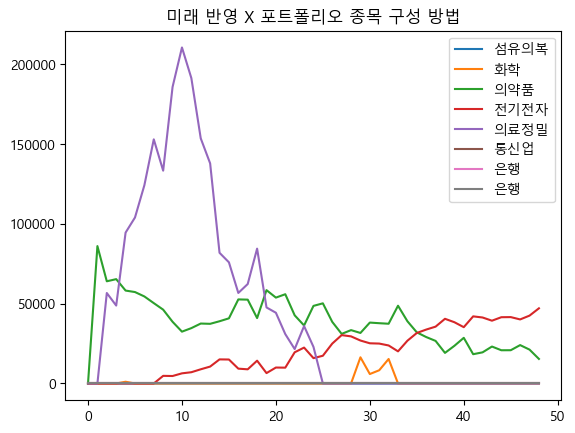

In [ ]:
#plt.plot(sol_2.iloc[:,0], label = '섬유의복')
plt.plot(sol_2.iloc[:,2], label = '섬유의복')
plt.plot(sol_2.iloc[:,3], label = '화학')
plt.plot(sol_2.iloc[:,4], label = '의약품')
plt.plot(sol_2.iloc[:,8], label = '전기전자')
plt.plot(sol_2.iloc[:,9], label = '의료정밀')
plt.plot(sol_2.iloc[:,12], label = '통신업')
plt.plot(sol_2.iloc[:,17], label = '은행')
plt.plot(sol_2.iloc[:,19], label = '은행')

plt.legend()
plt.title('미래 반영 X 포트폴리오 종목 구성 방법')
plt.show()

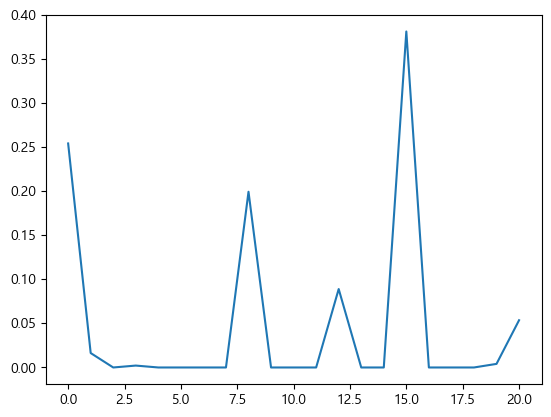

In [ ]:
plt.plot(dict(cleaned_weights).values())

(array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],


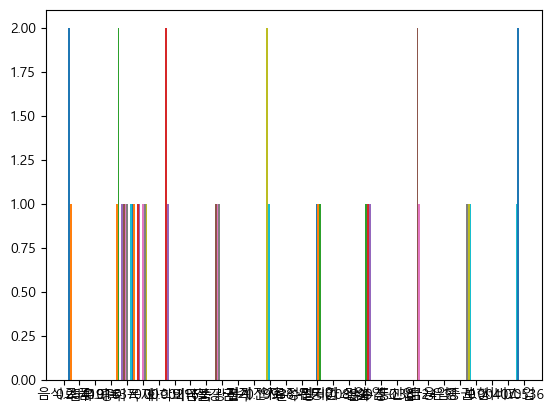

In [ ]:
plt.hist(cleaned_weights.items())